<a href="https://colab.research.google.com/github/pharringtonp19/business-analytics/blob/main/notebooks/JudgeIV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **Import Libraries**

In [134]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from functools import partial
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

### **Parameters**

In [135]:
n = 5000
j = 10
key = jax.random.PRNGKey(0)

In [136]:
def Income(foreclosed, x, key):
  return -0.5*foreclosed  + x -0.25*x*foreclosed + jax.random.normal(key)

In [137]:
def Foreclosed(z, x, key):
  scalar = -z + x -z*x
  return jax.random.bernoulli(key, p=scalar).astype(jnp.float32)

In [138]:
def Individual_sample(z, key):
  k1, k2, k3 = jax.random.split(key, 3)
  x = jax.random.normal(k1)
  d = Foreclosed(z, x, k2)
  y = Income(d, x, k3)
  return y, d, z, x

def Batch_sample(zs, keys):
  y, d, z, x = jax.vmap(Individual_sample, in_axes=(0, 0))(zs, keys)
  y, d, z, x = y.reshape(-1,1), d.reshape(-1,1), z.reshape(-1,1), x.reshape(-1,1)
  return y, d, z, x

def IV(y, d, z, x):
  regs1 = jnp.hstack((z, jnp.ones_like(d), x))
  dhat = regs1 @ jnp.linalg.lstsq(regs1, d)[0]
  regs2 = jnp.hstack((dhat, jnp.ones_like(d), x))
  return jnp.linalg.lstsq(regs2, y)[0][0]

def OLS(y, d, z, x):
  regs = jnp.hstack((d, jnp.ones_like(d), x))
  return jnp.linalg.lstsq(regs, y)[0][0]


In [139]:
def simulate_cluster(j, n, key):
  k1, k2 = jax.random.split(key)
  zs = jax.random.uniform(k1, minval=0.3, maxval=0.7, shape=(j,))
  zs = jnp.repeat(zs, n // j)
  y, d, z, x = Batch_sample(zs, jax.random.split(k2, n))
  return IV(y, d, z, x)

def simulate_iid(n, key):
  k1, k2 = jax.random.split(key)
  zs = jax.random.uniform(k1, minval=0.3, maxval=0.7, shape=(n,))
  y, d, z, x = Batch_sample(zs, jax.random.split(k2, n))
  return IV(y, d, z, x)

def simulate_ols_iid(n, key):
  k1, k2 = jax.random.split(key)
  zs = jax.random.uniform(k1, minval=0.3, maxval=0.7, shape=(n,))
  y, d, z, x = Batch_sample(zs, jax.random.split(k2, n))
  return OLS(y, d, z, x)

In [140]:
f_cluster = partial(simulate_cluster, j, n)
results_cluster = jax.vmap(f_cluster)(jax.random.split(key, 1000))

In [141]:
f_iid = partial(simulate_iid, n)
results_iid = jax.vmap(f_iid)(jax.random.split(key, 1000))

In [142]:
f_iid_ols = partial(simulate_ols_iid, n)
results_iid_ols = jax.vmap(f_iid_ols)(jax.random.split(key, 1000))

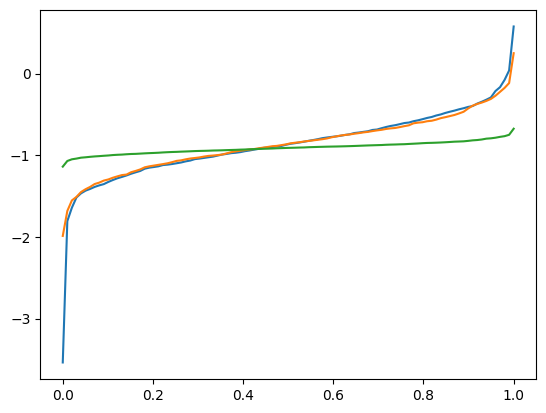

In [143]:
xs = jnp.linspace(0, 1, 100)
ys_cluster = jax.vmap(jnp.quantile, in_axes=(None, 0))(results_cluster, xs)
ys_iid = jax.vmap(jnp.quantile, in_axes=(None, 0))(results_iid, xs)
ys_iid_ols = jax.vmap(jnp.quantile, in_axes=(None, 0))(results_iid_ols, xs)
plt.plot(xs, ys_cluster)
plt.plot(xs, ys_iid)
plt.plot(xs, ys_iid_ols)
plt.show()

In [144]:
print(jnp.std(results_cluster))
print(jnp.std(results_iid))
print(jnp.std(results_iid_ols))

0.38004786
0.33451352
0.07047394


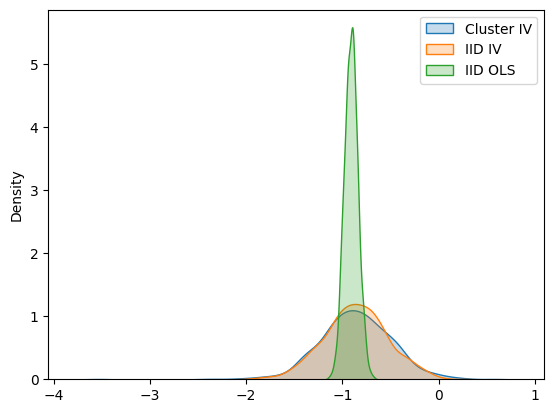

In [145]:
# Assuming results_cluster and results_iid are arrays or lists of data
sns.kdeplot(results_cluster.reshape(-1,), label="Cluster IV", shade=True)
sns.kdeplot(results_iid.reshape(-1,), label="IID IV", shade=True)
sns.kdeplot(results_iid_ols.reshape(-1,), label="IID OLS", shade=True)
# Add labels and show plot
plt.legend()
plt.show()